In [154]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# The Lincoln Met Data

The Lincoln Met site is a high standard meteorological site approximately 25 km from the trial site at Leeston.  This data is used as a reference to check the met data recorded locally at the trial in Leeston

## Bring in the Lincoln met data

In [155]:
LincolnRawData = pd.read_csv('Lincoln.met', index_col= False, sep = '\t', names =['Year','Day','TMIN','TMAX','RAIN','SRAD','WIND','VPRS'])
LincolnRawData.set_index(['Year','Day'],inplace=True,drop=False)
LincolnRawData.where(LincolnRawData>-90,np.nan,inplace=True)

## Make graphs of long term means

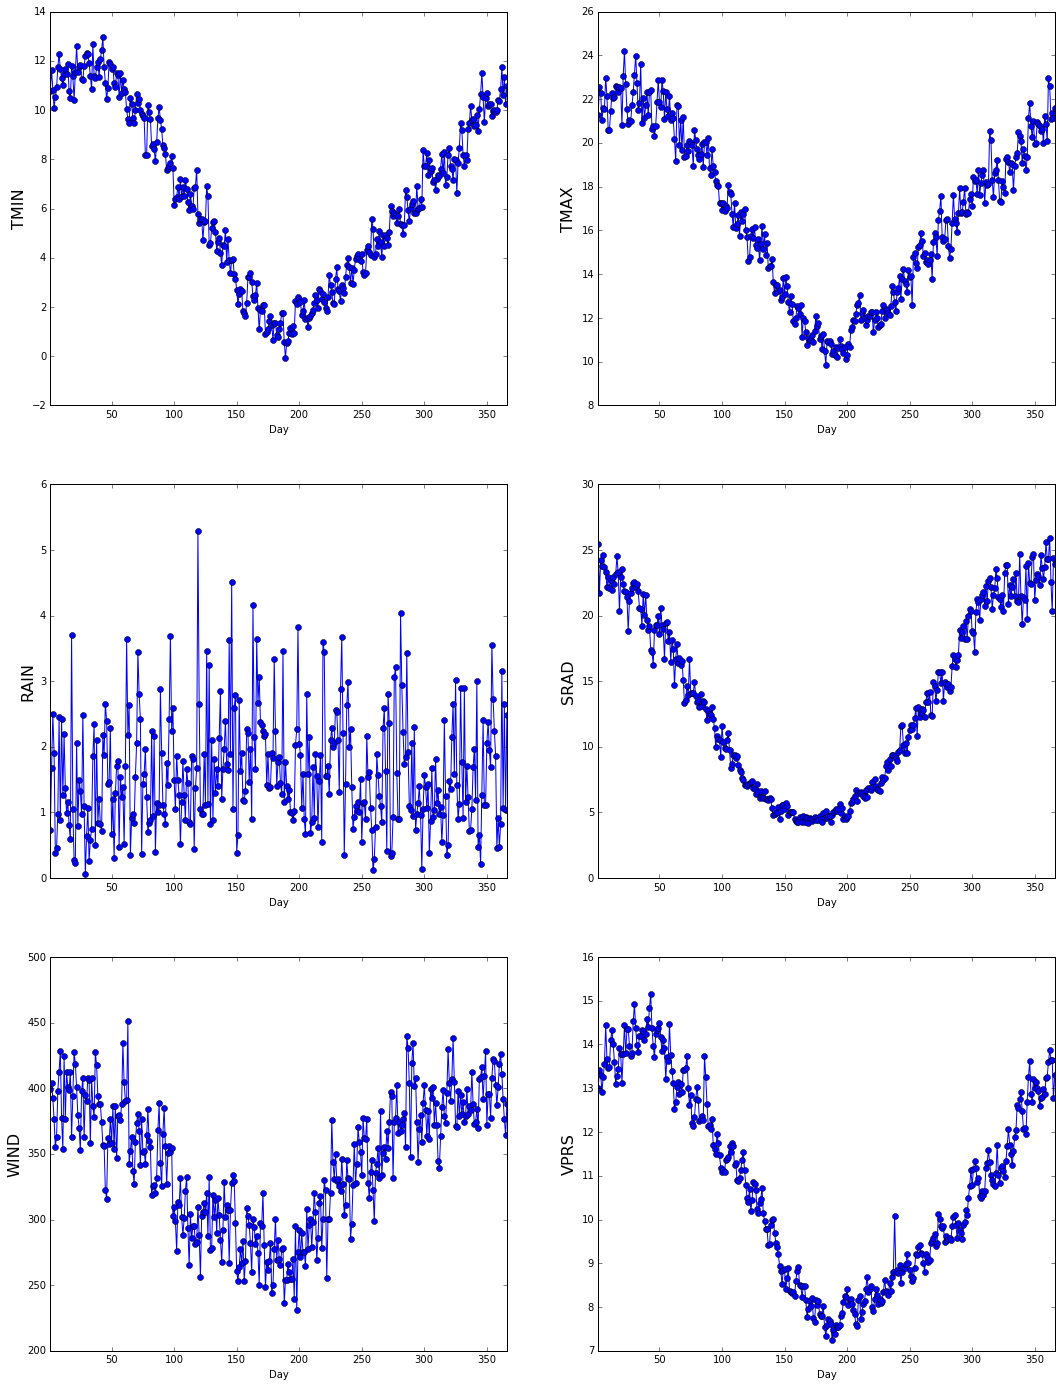

In [156]:
Fig = plt.figure(figsize = (18,24))
Position = 1
for x in [u'TMIN', u'TMAX', u'RAIN', u'SRAD', u'WIND', u'VPRS']:
    Fig.add_subplot(3,2,Position)
    Means = LincolnRawData.groupby(level='Day').mean()
    Means.ix[:,x].plot(marker='o')
    plt.ylabel(x,fontsize = 16)
    Position +=1

## Some pretty summary graphs

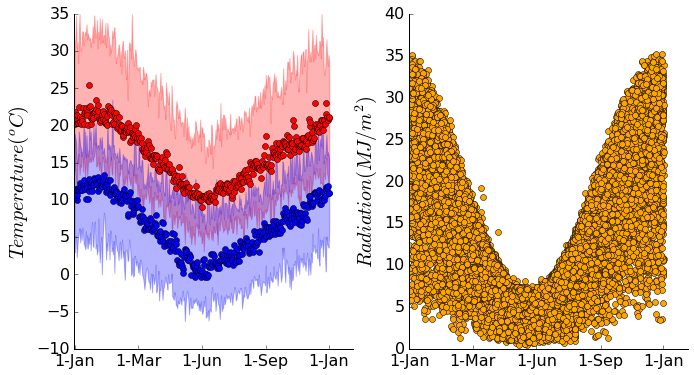

In [157]:
Fig = plt.figure(figsize = (11,6))
#for x in [u'TMIN', u'TMAX', u'RAIN', u'SRAD', u'WIND', u'VPRS']:
Ax = Fig.add_subplot(1,2,1)
plt.tick_params(labelsize=16)
Ax.spines['right'].set_visible(False)
Ax.spines['top'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
plt.tick_params(axis='y', which='both', left='on',right='off', labelbottom='on')
Medians = LincolnRawData.ix[:,'TMAX'].groupby(level='Day').median()
#SEs = LincolnRawData.groupby(level='Day').std()
Upper = LincolnRawData.ix[:,'TMAX'].groupby(level='Day').max()
Lower = LincolnRawData.ix[:,'TMAX'].groupby(level='Day').min()
plt.fill_between(Medians.index,
                     Upper,
                     Lower,
                alpha = 0.3,color='r')
plt.plot(Medians,'o',color='r')
Medians = LincolnRawData.ix[:,'TMIN'].groupby(level='Day').median()
#SEs = LincolnRawData.groupby(level='Day').std()
Upper = LincolnRawData.ix[:,'TMIN'].groupby(level='Day').max()
Lower = LincolnRawData.ix[:,'TMIN'].groupby(level='Day').min()
plt.fill_between(Medians.index,
                     Upper,
                     Lower,
                alpha = 0.3,color='b')
plt.plot(Medians,'o',color='b')
plt.ylabel(r'$Temperature (^oC)$',fontsize=20)
Ax.set_xticks([1,92,183,275,365])
Ax.set_xticklabels(['1-Jan','1-Mar','1-Jun','1-Sep','1-Jan'])
Ax = Fig.add_subplot(1,2,2)
plt.tick_params(labelsize=16)
Ax.spines['right'].set_visible(False)
Ax.spines['top'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
plt.tick_params(axis='y', which='both', left='on',right='off', labelbottom='on')
DayIndexed = LincolnRawData.copy()
DayIndexed.index = DayIndexed.index.droplevel('Year')
plt.plot(DayIndexed.index,DayIndexed.ix[:,'SRAD'],'o',color='orange')
plt.ylabel(r'$Radiation (MJ/m^2)$',fontsize=20)
Ax.set_xticks([1,92,183,275,365])
Ax.set_xticklabels(['1-Jan','1-Mar','1-Jun','1-Sep','1-Jan'])

# Clean up the Lincoln data where necessary

## Replace suspect data with nan

In [158]:
Lincoln = LincolnRawData.copy()
Lincoln.ix[:,'TMIN'].where(Lincoln.ix[:,'TMIN']>-10,np.nan,inplace=True)
Lincoln.ix[:,'TMAX'].where(Lincoln.ix[:,'TMAX']<35,np.nan,inplace=True)
Lincoln.ix[:,'RAIN'].where(Lincoln.ix[:,'RAIN']<200,np.nan,inplace=True)
Lincoln.ix[:,'SRAD'].where(Lincoln.ix[:,'SRAD']<35,np.nan,inplace=True)
Lincoln.ix[:,'WIND'].where(Lincoln.ix[:,'WIND']<2000,np.nan,inplace=True)
Lincoln.ix[:,'VPRS'].where(Lincoln.ix[:,'VPRS']<30,np.nan,inplace=True)

## The replace the nan's with long term mean

In [159]:
for var in [u'TMIN', u'TMAX', u'RAIN', u'SRAD', u'WIND', u'VPRS']:
    for x in Lincoln.index:
        Day = Lincoln.ix[x,'Day']
        if Lincoln.ix[x,var] == np.nan:
            Lincoln.ix[x,var] = Means.ix[Day,var]

## Put in a Date column into lincoln Data

In [160]:
for x in Lincoln.index:
    OneDate = datetime.datetime(Lincoln.ix[x,'Year'],1,1)
    JDayLessOne = int(Lincoln.ix[x,'Day']-1)
    TodayDate = OneDate + datetime.timedelta(JDayLessOne)
    Lincoln.ix[x,'Date'] = TodayDate

## Graph cleaned data to make sure all is OK

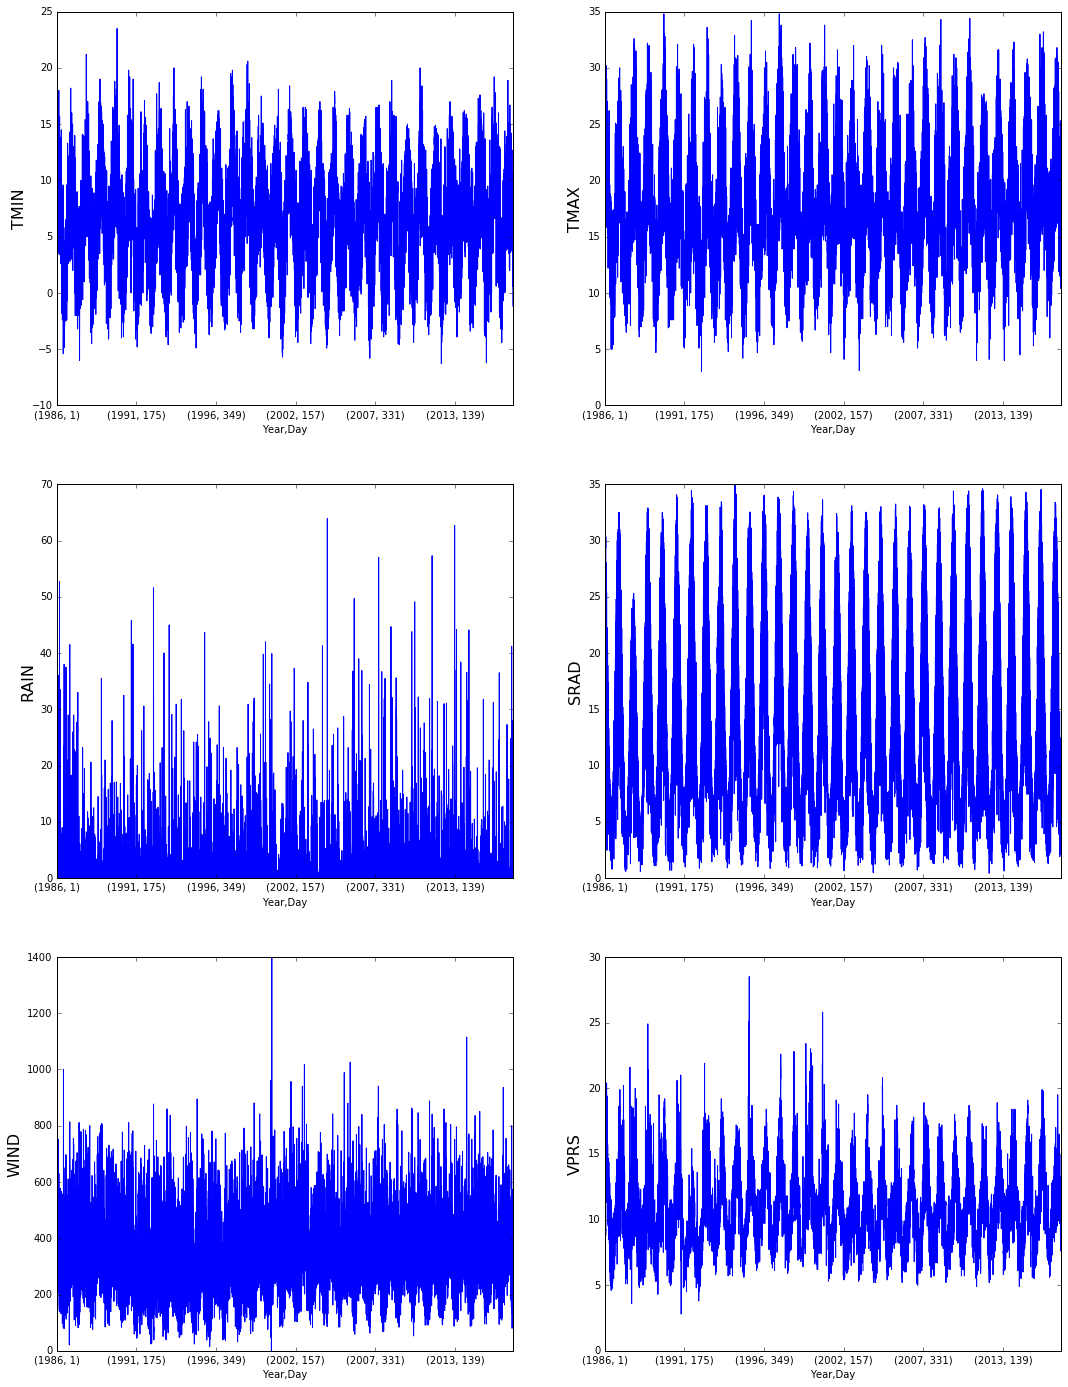

In [161]:
Fig = plt.figure(figsize = (18,24))
Position = 1
for x in [u'TMIN', u'TMAX', u'RAIN', u'SRAD', u'WIND', u'VPRS']:
    Fig.add_subplot(3,2,Position)
    Lincoln.ix[:,x].plot()
    plt.ylabel(x,fontsize = 16)
    Position +=1

## Set the date as index to enable matching with Leeston data

In [162]:
Lincoln.set_index('Date',inplace=True)

# The Leeston data. 
Temperature, solar radiation and rainfall measured at the site for each year of trial

## Bring in the 2013/14 data

In [163]:
Leeston1314 = pd.read_excel('D:\\GitHubRepos\\2020\\Weather\\Leeston1314.xlsx',
              skiprows=4,header = None,na_values='NAN')
Leeston1314.columns =['DATE','Rec','TMIN','TTMINime','TMAX','tTMAXime','RAIN','kw','SRAD']
Leeston1314.set_index('DATE',inplace=True)
Leeston1314.index = Leeston1314.index - datetime.timedelta(days=1)
Leeston1314.drop(['Rec','TTMINime','tTMAXime','kw'],axis=1,inplace=True)

## Regress against Lincoln data to check

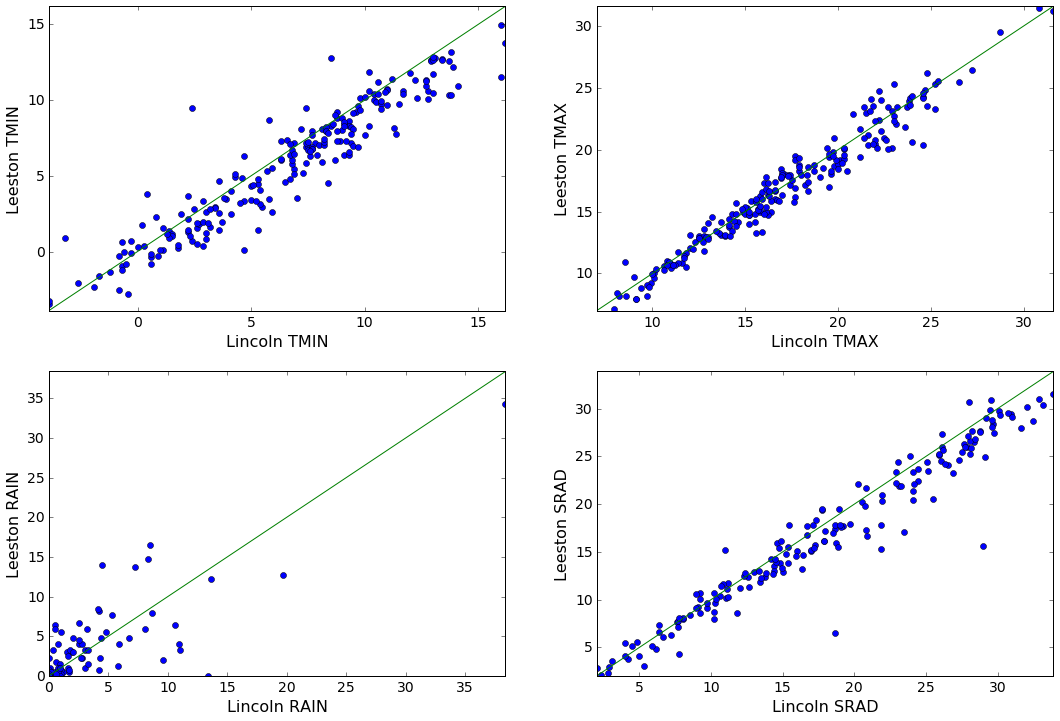

In [164]:
Fig = plt.figure(figsize = (18,12))
Position = 1
for x in [u'TMIN', u'TMAX', u'RAIN', u'SRAD']:
    Fig.add_subplot(2,2,Position)
    #plt.plot(Leeston1314.ix[:,x])
    Ind = Leeston1314.ix[:,x].index
    plt.plot(Lincoln.ix[Ind,x],Leeston1314.ix[:,x],'o')
    maxx = Lincoln.ix[Ind,x].max()
    minx = Lincoln.ix[Ind,x].min()
    plt.ylim(minx,maxx)
    plt.xlim(minx,maxx)
    plt.ylabel('Leeston '+x,fontsize=16)
    plt.xlabel('Lincoln '+x,fontsize=16)
    plt.tick_params(labelsize=14)
    plt.plot([minx,maxx],[minx,maxx],'-')
    Position +=1

### Good agreement between Leeston and Lincoln data suggesting met data recoreded on site is good and that Lincoln data can be used to gap fill Leeston data


## Bring in Leeston data for the next year

In [165]:
Leeston1415hourly = pd.read_excel('D:\\GitHubRepos\\2020\\Weather\\Leeston1415.xlsx',
              skiprows=4,header = None,na_values='NAN')
Leeston1415hourly.columns =['DATETime','Rec','RAIN','TMIN','TTMINime','TMAX','tTMAXime','kw','SRAD']
Leeston1415hourly.set_index('DATETime',inplace=True)
Leeston1415hourly.drop(['Rec','TMIN','TTMINime','tTMAXime','TMAX','kw'],axis=1,inplace=True)
Leeston1415 = Leeston1415hourly.resample('d').sum()
#apply calibratin coefficient to get radiation into correct units
Leeston1415.ix[:,'SRAD'] = Leeston1415.ix[:,'SRAD'].multiply(43)

## Join with other Leeston data and remove any errant values

In [166]:
LeestonLocal = pd.concat([Leeston1314,Leeston1415])
LeestonLocal.ix[:,'TMIN'].where(LeestonLocal.ix[:,'TMIN']>-10,np.nan,inplace=True)
LeestonLocal.ix[:,'TMAX'].where(LeestonLocal.ix[:,'TMAX']<35,np.nan,inplace=True)
LeestonLocal.ix[:,'RAIN'].where(LeestonLocal.ix[:,'RAIN']<200,np.nan,inplace=True)
LeestonLocal.ix[:,'SRAD'].where(LeestonLocal.ix[:,'SRAD']<35,np.nan,inplace=True)

## Make an empty DataFrame with all the met data needed for APMIP over the dates required and include the Leeston weather measured on site

In [167]:
start = datetime.datetime(2013,01,01)
end = datetime.datetime(2015,07,02)
DateIndex = pd.to_datetime([start + datetime.timedelta(days=x) for x in range(0, (end-start).days)])
Leeston = pd.DataFrame(index = DateIndex,
                       columns = [u'TMIN', u'TMAX', u'RAIN', u'SRAD', u'WIND', u'VPRS'],  
                       data = np.nan)
Leeston.index.name = 'Date'
Leeston.update(LeestonLocal)

## This DataFrame contains a number of gaps so plug the gaps with Lincoln met data

In [168]:
for var in [u'TMIN', u'TMAX', u'RAIN', u'SRAD', u'WIND', u'VPRS']:
    for x in Leeston.index:
        if np.isnan(Leeston.ix[x,var]):
            Leeston.ix[x,var] = Lincoln.ix[x,var]

## The figure below displays the met data included in the Leeston met file with the green data being measured on site and the blue data being measured at the nearby Lincoln site

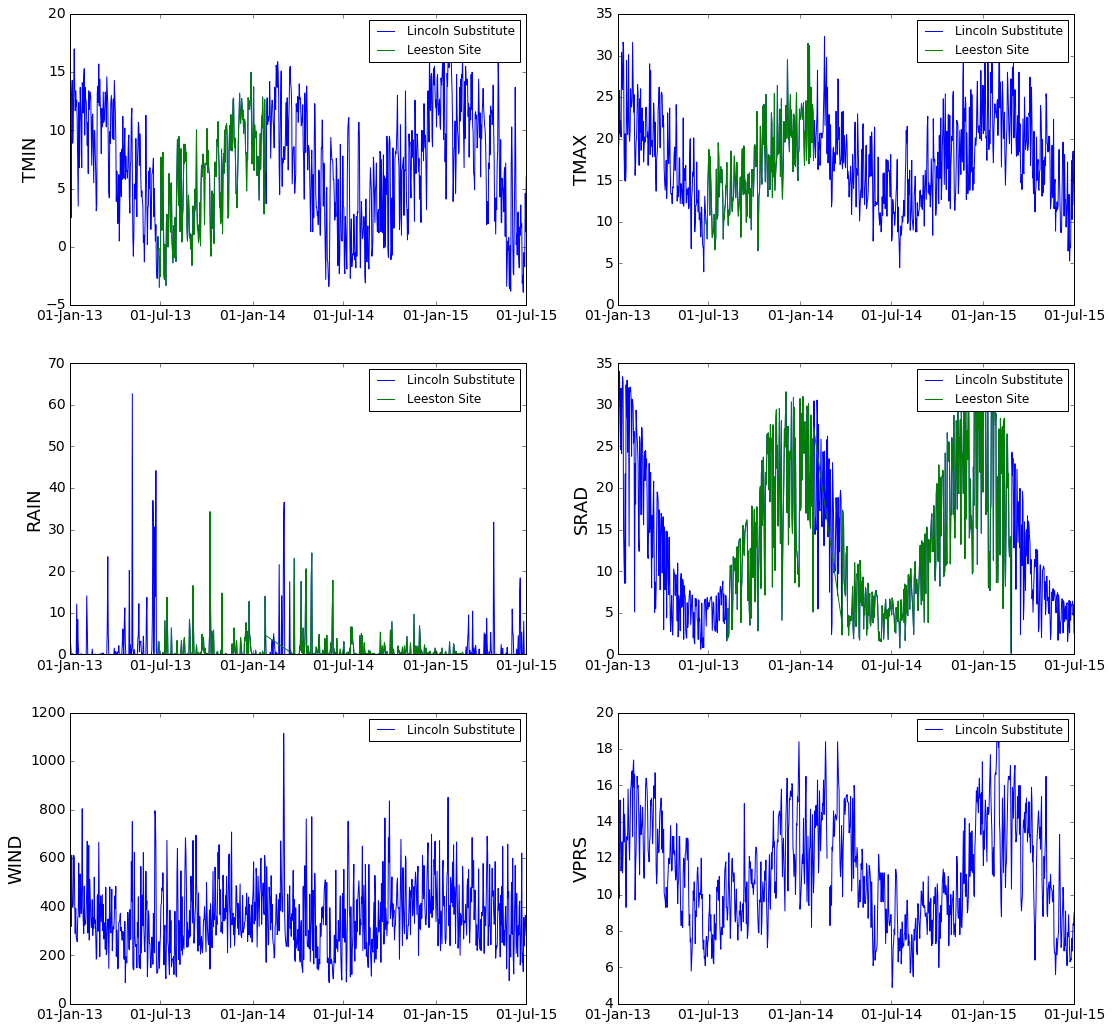

In [169]:
Fig = plt.figure(figsize = (18,24))
Position = 1
for x in [u'TMIN', u'TMAX', u'RAIN', u'SRAD', u'WIND', u'VPRS']:
    axis = Fig.add_subplot(4,2,Position)
    plt.plot(Leeston.ix[:,x],label = 'Lincoln Substitute')
    try:
        plt.plot(LeestonLocal.ix[:,x],label = 'Leeston Site')
    except:
        dummy = 'dumbass'
    plt.legend()
    plt.ylabel(x,fontsize=18)
    plt.tick_params(labelsize=14)
    axis.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    Position +=1

## Export the Data to a csv file.

In [170]:
Leeston.to_csv('Leeston.met')